# Forschungspraktikum SS20 
# Semantic Differentials for Wikipedia using the POLAR Framework


The POLAR Framework is a method that enables Interpretability for pre-trained word embeddings. The goal of this project is to produce word embeddings from a Wikipedia dataset, and deploy the POLAR framework to different categories of words (e.g. Countries, Politicians, Music, etc) in order to explain the semantic associations behind concepts on Wikipedia. An evaluation setup should assess the quality of the semantic differentials produced.

In [16]:
import gensim
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import multiprocessing
from gensim.corpora.wikicorpus import WikiCorpus #https://radimrehurek.com/gensim/corpora/wikicorpus.html
from gensim.models.word2vec import Word2Vec
# for 2d visalization (def display_closestwords_tsnescatterplot):
from sklearn.manifold import TSNE

#From Polar
import gensim
from numpy import linalg

from sklearn.metrics.pairwise import cosine_similarity
# progress bar for .ipyth 
from tqdm import tqdm_notebook as tqdm
import time
from random import shuffle
import sys
import nltk 
from nltk.corpus import wordnet 
import gc
from collections import defaultdict
import random
import json
import os

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile

from gensim.test.utils import datapath
#%load_ext autotime

import subprocess
#for saving and loading vectors/lists on disk
import pickle

# Load the Antonyms into memory

In [17]:
def loadAntonyms(model,loadMusicAntonyms, loadCountryAntonyms,loadStandardAntonyms,loadFoodAntonyms): 
    current_model=model #= word2vec
    list_antonym = []
    if loadFoodAntonyms== True:    
        with open(r'Antonym_sets/food50.txt') as fp:
            for line in fp:
                parts = line.split()
                if parts[1]!=' ':
                    word1 = parts[0]
                    word2 = parts[1]
                    if word1 in current_model and word2 in current_model:
                        list_antonym.append((word1.strip().lower(), word2.strip().lower()))


    if loadCountryAntonyms== True:    
        with open(r'Antonym_sets/country50.txt') as fp:
            for line in fp:
                parts = line.split()
                if parts[1]!=' ':
                    word1 = parts[0]
                    word2 = parts[1]
                    if word1 in current_model and word2 in current_model:
                        list_antonym.append((word1.strip().lower(), word2.strip().lower()))
    if loadMusicAntonyms== True:
        with open(r'Antonym_sets/music50.txt') as fp:
            for line in fp:
                parts = line.split()
                if parts[0]!=' ':
                    word1 = parts[0]
                    word2 = parts[1]
                    if word1 in current_model and word2 in current_model:
                        list_antonym.append((word1.strip().lower(), word2.strip().lower()))

                        
#POLAR Framework code (https://github.com/Sandipan99/POLAR)
    if loadStandardAntonyms==True:
        with open(r'Antonym_sets/LenciBenotto.val') as fp:
            for line in fp:
                parts = line.split()
                if parts[3]=='antonym':
                    word1 = parts[0].split('-')[0]
                    word2 = parts[1].split('-')[0]
                    if word1 in current_model and word2 in current_model:
                        list_antonym.append((word1.strip().lower(), word2.strip().lower()))


        with open(r'Antonym_sets/LenciBenotto.test') as fp:
            for line in fp:
                parts = line.split()
                if parts[3]=='antonym':
                    word1 = parts[0].split('-')[0]
                    word2 = parts[1].split('-')[0]
                    if word1 in current_model and word2 in current_model:
                        list_antonym.append((word1.strip().lower(), word2.strip().lower()))

        with open(r'Antonym_sets/EVALution.val') as fp:
            for line in fp:
                parts = line.split()
                if parts[3]=='antonym':
                    word1 = parts[0].split('-')[0]
                    word2 = parts[1].split('-')[0]
                    if word1 in current_model and word2 in current_model:
                        list_antonym.append((word1.strip().lower(), word2.strip().lower()))

        with open(r'Antonym_sets/EVALution.test') as fp:
            for line in fp:
                parts = line.split()
                if parts[3]=='antonym':
                    word1 = parts[0].split('-')[0]
                    word2 = parts[1].split('-')[0]
                    if word1 in current_model and word2 in current_model:
                        list_antonym.append((word1.strip().lower(), word2.strip().lower()))


    list_antonym = list(dict.fromkeys(list_antonym).keys())
    return list_antonym

# Computing similarty between Antonyms

In [18]:
#POLAR Framework code (https://github.com/Sandipan99/POLAR) :
def computeFinalAntonymsSimilariy(list_antonym): 
    similarity_matrix = defaultdict(list)
    #pre processing of antonyms
    for each_pair in tqdm(list_antonym):
        word1 = each_pair[0]
        word2 = each_pair[1]
        if word1 < word2: ## welches wort länger ist
            similarity_matrix[word1].append(word2)                  #defaultdict(<class 'list'>, {'exclude': ['inscribe']})
            #print(similarity_matrix)
        else:
            similarity_matrix[word2].append(word1)

    # computing similarity of antonyms:
    all_similarity = defaultdict(dict)
    for each_key in tqdm(similarity_matrix):
        for each_value in similarity_matrix[each_key]:
    #       cosine_similarity
            all_similarity[each_key][each_value] = abs(cosine_similarity([current_model.wv[each_key]],[current_model.wv[each_value]])[0][0])

    
    final_antonym_list = []
    for index_counter, each_key in enumerate(tqdm(all_similarity)):
        listofTuples = sorted(all_similarity[each_key].items() ,  key=lambda x: x[1])
        final_antonym_list.append((each_key, listofTuples[0][0]))

    list_antonym = final_antonym_list
    return list_antonym, all_similarity

# Generate the ORTHOGONAL DIMENSION Order
# Subspace selection function

In [19]:
#POLAR Framework code (https://github.com/Sandipan99/POLAR)

import random

from scipy.spatial.distance import cosine as scipy_cosine
random.seed(42)

def computedimension_similarity_matrix(antonymy_vector):
    t1 = np.array(antonymy_vector)
    dimension_similarity_matrix = defaultdict(dict)
    for index_1, each_dim1 in enumerate(tqdm(t1)):
        for index_2, each_dim2 in enumerate(t1):
            dimension_similarity_matrix[index_1][index_2] = abs(1-scipy_cosine(each_dim1, each_dim2))
    return dimension_similarity_matrix
        
def get_set_score(final_list, each_dim,antonymy_vector,similaityMatrix):
    final_output = 0.0
    dimension_similarity_matrix=similaityMatrix
    for each_vec in final_list:
        final_output += dimension_similarity_matrix[each_vec][each_dim]
    return final_output/(len(final_list))
        
def select_subset_dimension(dim_vector, num_dim):
    working_list = np.array(dim_vector)
    
    working_position_index = [i for i in range(working_list.shape[0])]
    final_position_index = []
    similaityMatrix=computedimension_similarity_matrix(dim_vector)

    print('working list is ready, shape', working_list.shape)
    sel_dim = random.randrange(0, working_list.shape[0])

    final_position_index.append(sel_dim)
    
    working_position_index.remove(sel_dim)

    
    for test_count in tqdm(range(num_dim-1)):
        min_dim = None
        min_score = 1000
        for temp_index, each_dim in enumerate(working_position_index):
#             print(each_dim)
            temp_score = get_set_score(final_position_index, each_dim,dim_vector,similaityMatrix)
            if temp_score< min_score:
                min_score= temp_score
                min_dim = each_dim
        #print(test_count,min_dim)
        final_position_index.append(min_dim)
        working_position_index.remove(min_dim)
#         print(working_list.shape, len(final_list))
    return final_position_index

# Transform into Polar space function

In [20]:
#POLAR Framework code (https://github.com/Sandipan99/POLAR)
def transform_to_antonym_space(current_model, output_file_path, binary, current_antonymy_vector_inverse):
    embedding_size = orthogonal_antonymy_vector.shape[0] #current_antonymy_vector_inverse.shape[0]   ##CHANGE THIS ACCORDINGLY!!!
    print('New model size is',len(current_model.wv.vocab), embedding_size)

    temp_file = None
    
    if binary:
        temp_file = open(output_file_path,'wb')
        temp_file.write(str.encode(str(len(current_model.wv.vocab))+' '+str(embedding_size)+'\n'))
    else:
        temp_file = open(output_file_path,'w')
        temp_file.write(str(len(current_model.wv.vocab))+' '+str(embedding_size)+'\n')

    total_words = 0
    for each_word in tqdm(current_model.wv.vocab):
        total_words += 1
        if binary:
            temp_file.write(str.encode(each_word+' '))
        else:
            temp_file.write(each_word+' ')

        new_vector = np.matmul(current_antonymy_vector_inverse,current_model[each_word])

        new_vector = new_vector/linalg.norm(new_vector)

        
        
        if binary:
            temp_file.write(new_vector)
            temp_file.write(str.encode('\n'))
        else:
            temp_file.write(str(new_vector))
            temp_file.write('\n')


    temp_file.close()



# Standard Normal transform

In [21]:
#POLAR Framework code (https://github.com/Sandipan99/POLAR)
def standard_normal_dist_model(model, new_filename):
    embedding_matrix = []
    embedding_vocab = []

    temp_file = open(new_filename,'wb')
    temp_file.write(str.encode(str(model.vectors.shape[0])+' '+str(model.vectors.shape[1])+'\n'))
    
    for each_word in tqdm(model.wv.vocab):
        embedding_matrix.append(model[each_word])
        embedding_vocab.append(each_word)
    
    embedding_matrix = np.array(embedding_matrix)
    
    print('The shape of embedding matrix is {}'.format(embedding_matrix.shape))
    
    norm_embedding_matrix = (embedding_matrix - embedding_matrix.mean(0))/ embedding_matrix.std(0)
    
    for word_counter, each_word in enumerate(tqdm(embedding_vocab)):
#         assert each_word==embedding_vocab[word_counter],'Not matching!!!'
        
        temp_file.write(str.encode(each_word+' '))
        new_vector = norm_embedding_matrix[word_counter]
        temp_file.write(new_vector)
        temp_file.write(str.encode('\n'))
        
    del embedding_matrix
    del embedding_vocab
    temp_file.close()

# Visulizing polar dimensions

In [22]:
# this function plots the value of a word on a polar dimension in 2d
def plotPolar(left, right, value):
    fig, ax1 = plt.subplots()
    fig.set_figheight(1)
    
    if abs(value)>10:
        fig.set_figwidth(20)
        ar = np.arange(-20,21)   
    else:
        fig.set_figwidth(10)
        ar = np.arange(-10,11)
    ax1.plot(ar, np.zeros_like(ar) + 0, '.')
    ax1.plot(value, 0, 'd', linewidth=2, markersize=20, color='r')
    ax1.set_ylabel(left, color='b',rotation=0, size=20, labelpad=50)
    ax1.set_yticks([])
    ax1.set_xticks(ar)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)

    ax2 = ax1.twinx()
    ax2.set_ylabel(right, color='r',rotation=0, size=20, labelpad=50)
    ax2.set_yticks([])
    ax1.grid(False)
    ax2.grid(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    
    
    
    fig.tight_layout()
    plt.show()

In [23]:
# This function Plots the value for the top 'numberPolar' dimensions of a word
import matplotlib.pyplot as pp
def getMeaningOfWord(strWord,antonymy_vector, model, numberPolar ):
    #print(antonymy_vector)
    word=model[strWord]
    thisdict = {}
    for count, value in enumerate(word):
        thisdict[count]= value
    sortedDic=sorted(thisdict.items(), key=lambda item: abs(item[1]))
    sortedDic.reverse()
   
    for i in range(0,numberPolar):
        cur_Index=sortedDic[i][0]
        originalAntonymIndex=antonymy_vector[cur_Index]
        print(sortedDic[i][1])
        if cur_Index<50:
            print("Original")
        else:
            print("Extended")
        cur_value =sortedDic[i][1]
        leftPolar=list_antonym[originalAntonymIndex][0]
        rightPolar=list_antonym[originalAntonymIndex][1]
        plotPolar(rightPolar, leftPolar, cur_value)
    

# Use wordnet to generate more antonyms

In [24]:
import nltk
nltk.download('wordnet')
 

from nltk.stem import PorterStemmer
from nltk.corpus import wordnet 
def addAntonyms(list_antonym, n):  
    porter = PorterStemmer()
    #Add n synonyms of the already existing pairs to the list
    potentialPair=[]
    for curAnto in list(sum(list_antonym, ())): #flatten the list of tuples
        counter=0# only add maximal n synonyms
        for syn in wordnet.synsets(curAnto): #access wordnet 
            for l in syn.lemmas(): 
                curName=l.name()
                if counter>n-1:
                    break       
                if curName!=str(curAnto) and curName not in potentialPair: #check if its not the same word/ same word stem porter.stem(l.name())
                    if curName in word2vec.wv.vocab:
                        potentialPair.append(curName)
                        counter+=1   

  
    newAnto=[]
    for leftPair in potentialPair:
        for syn in wordnet.synsets(leftPair): 
            for l in syn.lemmas(): 
                if l.antonyms(): 
                    rightPair=l.antonyms()[0].name()
                    curSet=(leftPair,rightPair)
                    curSetStemmed=(leftPair,porter.stem(rightPair))
                    if curSet not in newAnto and curSetStemmed not in curSetStemmed: #don't add already added pairs or their stemms
                        if rightPair in word2vec.wv.vocab:
                            newAnto.append(curSet)
    print("The following antonym pairs have been added:")
    print(newAnto)
    finalAnto=list_antonym
    finalAnto.extend(newAnto)
    return finalAnto
#testlist_antonym=list_antonym.copy()
#finalAnto=addAntonyms(testlist_antonym, 2)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Use https://www.synonyms.com/ to get more antonym pairs, can be slow

In [25]:
import requests
from bs4 import BeautifulSoup
def getAntonymsForWordSynonymsCom(word, model, n):
    curWord=word
    webSite="https://www.synonyms.com/antonyms/"
    response = requests.get(webSite+curWord)
    #print(response)
    antonyms=[]
    counter=0
    if response.status_code== 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        section = soup.findAll('p', {'class': 'ants'})#All
        #print(section)
        for sec in section:
            for li in sec.findAll('a'):
                if li.text in model.wv.vocab:   
                    antonyms.append(li.text)
                    counter+=1
                    if counter==2:                       
                        return antonyms
    return antonyms    
        
#getAntonymsForWordSynonymsCom("dark", word2vec, 2)

In [26]:


def generateNewPairs(model, originalPairs,n):
    curVocab=list(sum(originalPairs, ())) #flatten the list of tupels 
    newPairs=originalPairs
    for word in curVocab:
        similarWords=model.most_similar(word)[0:5]
        for simWord in similarWords:
            wordText=simWord[0]
            antonyms=getAntonymsForWordSynonymsCom(wordText, model, 2)
            for ant in antonyms:
                pair=(wordText,ant)
                pair2=(ant,wordText) #
                if pair not in newPairs and pair2 not in newPairs:
                    newPairs.append(pair)
                    
    return newPairs
#generateNewPairs(word2vec, list_antonym,2)    

In [27]:
def addSimilarWords(model, originalPairs):
    curVocab=list(sum(originalPairs, ())) #flatten the list of tupels 
    newPairs=originalPairs
    for word in curVocab:
        similarWords=model.most_similar(word)[0:5]
        for simWord in similarWords:
            simWord=simWord[0]
            for syn in wordnet.synsets(simWord): 
                for l in syn.lemmas():
                    counter=0
                    if l.antonyms(): 
                        rightPair=l.antonyms()[0].name()
                        curSet=(simWord,rightPair)
                        curSetBackwards=(rightPair,simWord)
                        if curSet not in newPairs and curSetBackwards not in newPairs: #don't add already added pairs or their stemms
                            if rightPair in word2vec.wv.vocab:
                                newPairs.append(curSet)
                                counter+=1
                                if counter==5:
                                    break
    return newPairs

# Real code starts here

# Only run next cell if a new Wikipedia dataset is loaded

In [28]:
from ipywidgets import interact, interactive, fixed, interact_manual

def myFunction(trainNewModel):
    return trainNewModel
print("Check if its your first time running this NodeBook")
trainNewModel=interact(myFunction, trainNewModel=True);

Check if its your first time running this NodeBook


interactive(children=(Checkbox(value=True, description='trainNewModel'), Output()), _dom_classes=('widget-inte…

In [29]:
trainNewModel=False
if trainNewModel==True:
    wiki = WikiCorpus(r"DataSets/enwiki-20200601-pages-articles-multistream1.xml-p1p30303.bz2", 
                  lemmatize=False, dictionary={})
    #store the preprocessed dataset, which reduces a lot of time later
    wiki.save('SavedWord2Vec/wiki.corpus')
    
    sentences = list(wiki.get_texts()) 



size: The number of dimensions of the embeddings and the default is 100.

window: The maximum distance between a target word and words around the target word. The default window is 5.

min_count: The minimum count of words to consider when training the model; words with occurrence less than this 
count will be ignored. The default for min_count is 5.

workers: The number of partitions during training and the default workers is 3.

sg: The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.

In [30]:
### Compute the Word2Vec model usint following parameters#
if trainNewModel==True:
    print("Training Word2Vec model ...")
    params = {'size': 300, 'window': 5, 'min_count': 5, 
          'workers': max(1, multiprocessing.cpu_count() - 1), 'sample': 1E-3,'sg' : 1}
    word2vec = Word2Vec(sentences, **params)
    ### Save Word2Vec model to file ###
    word2vec.save('SavedWord2Vec/wiki.word2vec.model')
    print("Finished Training")
else:
    ### Loading finished Word2Vec model to memory from file ###
    print("Loading Word2Vec model from file...")
    word2vec = Word2Vec.load('SavedWord2Vec/wiki.word2vec.model')
    print("Finished Loading")


Loading Word2Vec model from file...
Finished Loading


## King- Man + Woman = Queen?

In [31]:
def similarityNameVector(vec, name, model):
    cosineSimilarity = np.dot(vec, model.wv[name])/(np.linalg.norm(vec)* np.linalg.norm(model.wv[name]))
    return cosineSimilarity

print("Smiliarity of king and queen:", word2vec.wv.similarity('king', 'queen'))
ourQueen= word2vec.wv['king'] - word2vec.wv['man'] + word2vec.wv['woman']
print("Smiliarity of transformed king and queen:", similarityNameVector(ourQueen,'queen',word2vec))

print("The most similar words to out transformation of King to Queen are:")
display(word2vec.wv.most_similar(positive=[ourQueen], topn=10)) # cosine similarity
#word2vec.wv.most_similar(positive=["king"], topn=10)

ourJapan= word2vec.wv['france'] - word2vec.wv['paris'] + word2vec.wv['tokyo']
print("The most similar words to out transformation of France to Japan are:")
display(word2vec.wv.most_similar(positive=[ourJapan], topn=10)) # cosine similarity
#word2vec.wv.most_similar(positive=["king"], topn=10)

Smiliarity of king and queen: 0.62048626
Smiliarity of transformed king and queen: 0.59351194
The most similar words to out transformation of King to Queen are:


[('king', 0.7447922229766846),
 ('queen', 0.5935120582580566),
 ('regnant', 0.5319673418998718),
 ('woman', 0.5265816450119019),
 ('consort', 0.5225052237510681),
 ('berengaria', 0.5126684308052063),
 ('urraca', 0.5116742253303528),
 ('kings', 0.5031053423881531),
 ('isabeau', 0.5030635595321655),
 ('monarch', 0.4930773079395294)]

The most similar words to out transformation of France to Japan are:


[('tokyo', 0.7923076152801514),
 ('japan', 0.7168467044830322),
 ('osaka', 0.5796914100646973),
 ('kyushu', 0.5486371517181396),
 ('ehime', 0.5427321195602417),
 ('fukuoka', 0.5382509231567383),
 ('miyagi', 0.5322080850601196),
 ('ōita', 0.5318936705589294),
 ('chiba', 0.5310077667236328),
 ('hachiōji', 0.5294787287712097)]

# Generate Antonyms and then Transformation to polar space
## Parts were taken from the POLAR Framework code (https://github.com/Sandipan99/POLAR)

## Compute the task score for different dimension size

In [32]:
## POLAR Framework code (https://github.com/Sandipan99/POLAR) :
def generate_embedding_path(current_model, embedding_path, binary, antonym_vector, curr_dim):
    curr_antonym_vector = antonymy_vector[antonym_vector[:curr_dim]]
    curr_antonymy_vector_inverse = np.linalg.pinv(np.transpose(curr_antonym_vector))
    #transform to polar space and write3s to file
    transform_to_antonym_space(current_model, embedding_path, binary,curr_antonymy_vector_inverse)

In [50]:
#Put it all together

loadMusicAntonyms=False
loadCountryAntonyms=False
loadStandardAntonyms=False
loadFoodAntonyms=True
current_model=word2vec

list_antonym=loadAntonyms(model=word2vec,loadMusicAntonyms=loadMusicAntonyms, loadCountryAntonyms=loadCountryAntonyms,loadStandardAntonyms=loadStandardAntonyms,loadFoodAntonyms=loadFoodAntonyms)
print(len(list_antonym))

#Different methods to extend or generate pairs of antonyms:

## Use wordnet to generate more antonyms
#list_antonym=addAntonyms(list_antonym, 2)  

#add antonyms with synonyms.com and similarity
#list_antonym=generateNewPairs(word2vec, list_antonym,2) 

# add antonyms with wordnet and similarity
#list_antonym=addSimilarWords(word2vec, list_antonym)

# add antonyms from scratch (corpus needed see bottom of this ipynb)
#list_antonym=creatAntonymsFromCategory(genreCorpus,word2vec)

list_antonym, all_similarity=computeFinalAntonymsSimilariy(list_antonym)

nameTag="Food" #Standard #Food #Country #CountryExtended #Genre


with open("SavedWord2Vec/AntonymVector"+nameTag+".txt", "wb") as fp:   #Pickling
    pickle.dump(list_antonym, fp)


53


C:\Users\Jan\anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Jan\anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


C:\Users\Jan\anaconda3\lib\site-packages\ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


C:\Users\Jan\anaconda3\lib\site-packages\ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [51]:

## Find the antonym difference vectors
antonymy_vector = []
for each_word_pair in list_antonym:
    antonymy_vector.append(current_model.wv[each_word_pair[0]]- current_model.wv[each_word_pair[1]])
antonymy_vector = np.array(antonymy_vector)
print(antonymy_vector.shape)



# Get the orthogonal dimension order
if len(list_antonym)>300:
    num_antonym = 300#1468
    orthogonal_antonymy_vector =np.array(select_subset_dimension(antonymy_vector, num_antonym))  
else:
    num_antonym=len(list_antonym)-1
    orthogonal_antonymy_vector = np.array(range(num_antonym))



antonym_vector_method = orthogonal_antonymy_vector # we used only the orthogonality method from the original paper
with open("SavedWord2Vec/chosenAntonyms"+nameTag+".txt", "wb") as fp:   #Pickling
    pickle.dump(antonym_vector_method, fp)

curr_dim = len(antonym_vector_method)#dim_size

(47, 300)


In [52]:

embedding_path = r'SavedWord2Vec/polarEmbedding'+nameTag+str(curr_dim)
#embedding_path = r'polarEmbeddingFood265'   
# model is transformed to polar space and stored as a file
generate_embedding_path(current_model, embedding_path+'.bin',True,antonym_vector_method, curr_dim)

# Model is loaded from file to memory
print('loading the model')
temp_model = gensim.models.KeyedVectors.load_word2vec_format(embedding_path+'.bin', binary=True)
print('loading done..')


#Model is tranformed to standard normal and stored to file
  
std_nrml_embedding_path =embedding_path+'_StdNrml.bin'

standard_normal_dist_model(temp_model, std_nrml_embedding_path)

del temp_model


New model size is 147989 46


C:\Users\Jan\anaconda3\lib\site-packages\ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


C:\Users\Jan\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



loading the model
loading done..


C:\Users\Jan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':
C:\Users\Jan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



The shape of embedding matrix is (147989, 46)


C:\Users\Jan\anaconda3\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


## Our Testing

In [53]:
curr_dim = num_antonym
#embedding_path = r'SavedWord2Vec/polarEmbedding'+str(curr_dim)    
nameTag="Food"
embedding_path = r'SavedWord2Vec/polarEmbedding'+nameTag+str(curr_dim)
path=embedding_path+'_StdNrml.bin'
# Load the normalized model in Polar dimensions into memory
print("Load Polar model into memory")
word2vecPolar = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)
print("Finished Loading")

Load Polar model into memory
Finished Loading


In [54]:

with open("SavedWord2Vec/AntonymVector"+nameTag+".txt", "rb") as fp:   # Unpickling
    list_antonym = pickle.load(fp)
with open("SavedWord2Vec/chosenAntonyms"+nameTag+".txt", "rb") as fp:   # Unpickling
    orthogonal_antonymy_vector = pickle.load(fp)


3.4454765
Original


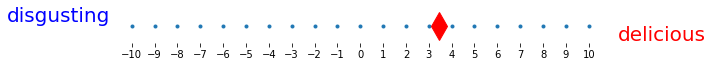

2.864344
Original


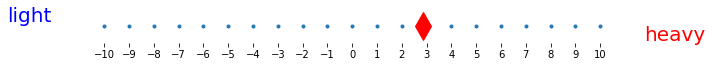

-1.9295162
Original


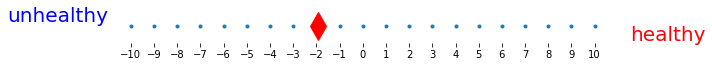

-1.794496
Original


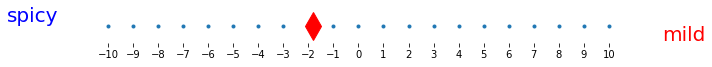

1.7554425
Original


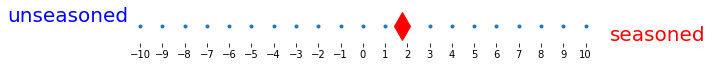

1.6231482
Original


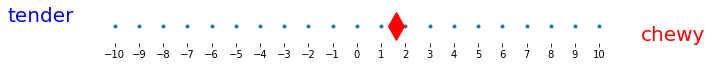

-1.585082
Original


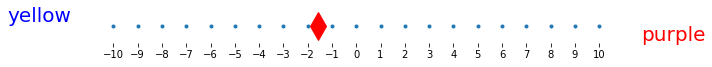

-1.456459
Original


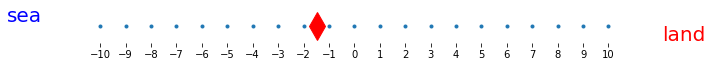

-1.3766145
Original


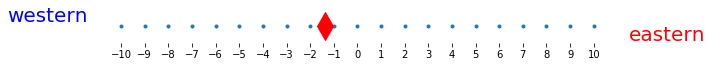

-1.3000264
Original


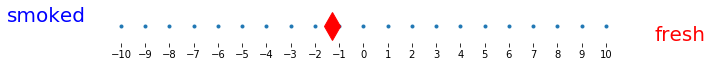

-1.2414747
Original


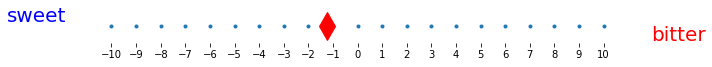

1.2160113
Original


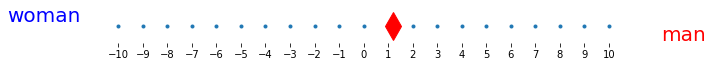

-1.195381
Original


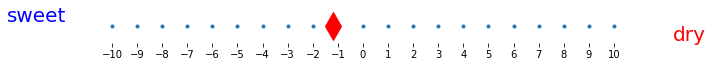

1.160061
Original


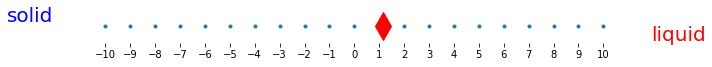

1.1503462
Original


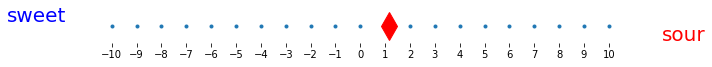

-1.1347961
Original


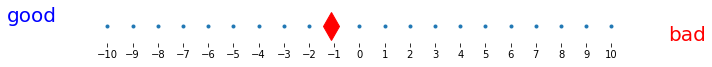

-1.0883931
Original


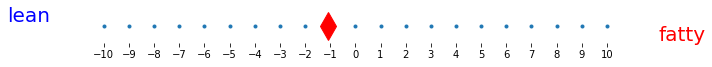

-0.98319227
Original


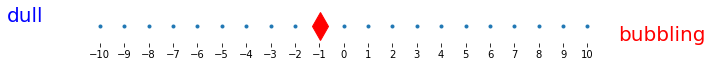

-0.94768417
Original


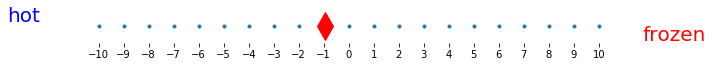

0.79517186
Original


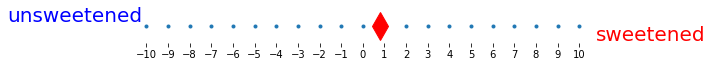

-0.7354782
Original


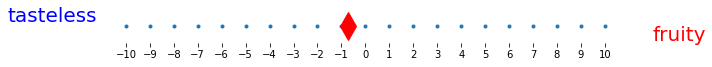

0.6925083
Original


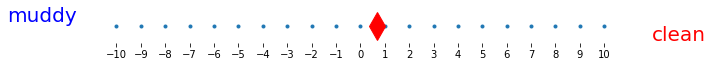

-0.67013216
Original


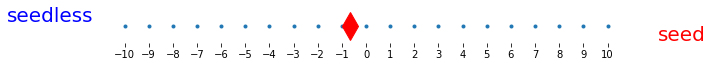

-0.65848047
Original


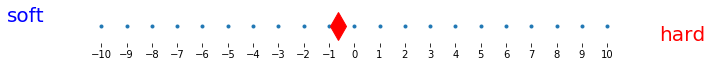

0.6447137
Original


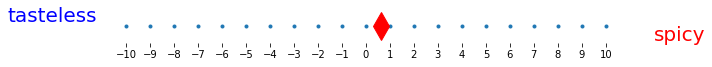

-0.6413256
Original


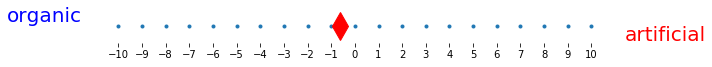

-0.6336265
Original


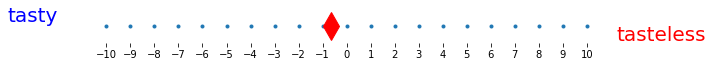

0.5403892
Original


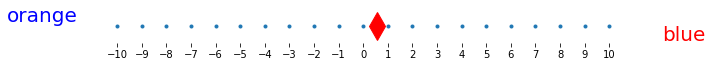

-0.46175
Original


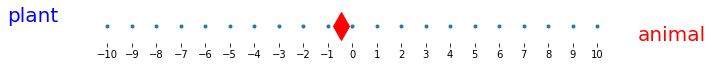

0.4585045
Original


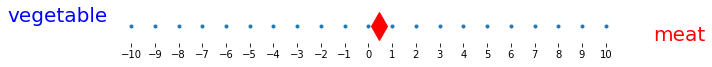

In [57]:
# Plot top 30 polar dimensions for a word
currWord='ramen'
howManyDimension=30

getMeaningOfWord(currWord,orthogonal_antonymy_vector, word2vecPolar, howManyDimension )

# Generate Antonyms from Scratch

In [36]:

def creatAntonymsFromCategory(document,current_model):  
    porter = PorterStemmer()
    #Add n synonyms of the already existing pairs to the list
    
    antonyms=[]
    for word in document.split(" "):
        for syn in wordnet.synsets(word): #access wordnet 
                typePos=syn.name()[1]
                for l in syn.lemmas(): 
                    #print(l.name())   
                    if l.antonyms():
                        pair=(l.name(),l.antonyms()[0].name())
                        if pair not in antonyms and pair[0] in current_model.wv.vocab and pair[1] in current_model.wv.vocab:
                            antonyms.append(pair)
    return antonyms

#creatAntonymsFromCategory(testChina,word2vecPolar)

## Old test code, not used

In [24]:
testUSA="The United States of America (USA), commonly known as the United States (U.S. or US) or America, is a country mostly located in central North America, between Canada and Mexico. It consists of 50 states, a federal district, five major self-governing territories, and various possessions.[h] At 3.8 million square miles (9.8 million km2), it is the world's third- or fourth-largest country by total area.[d] With a 2019 estimated population of over 328 million,[7] the U.S. is the third most populous country in the world. The capital is Washington, D.C., and the most populous city is New York City. Paleo-Indians migrated from Siberia to the North American mainland at least 12,000 years ago,[19] and European colonization began in the 16th century. The United States emerged from the thirteen British colonies established along the East Coast. Numerous disputes between Great Britain and the colonies led to the American Revolutionary War lasting between 1775 and 1783, leading to independence.[20] Beginning in the late 18th century, the United States vigorously expanded across North America, gradually acquiring new territories,[21] killing and displacing Native Americans, and admitting new states. By 1848, the United States spanned the continent.[21] Slavery was legal in much of the United States from the 17th to the second half of the 19th century, when the American Civil War led to its abolition.[22][23]The Spanish–American War and World War I entrenched the U.S. as a world power, a status confirmed by the outcome of World War II. It was the first country to develop nuclear weapons and is the only country to have used them in warfare. During the Cold War, the United States and the Soviet Union competed in the Space Race, culminating with the 1969 Apollo 11 mission, the spaceflight that first landed humans on the Moon. The end of the Cold War and collapse of the Soviet Union in 1991 left the United States as the world's sole superpower.[24]The United States is a federal republic and a representative democracy. It is a founding member of the United Nations, World Bank, International Monetary Fund, Organization of American States (OAS), NATO, and other international organizations. It is a permanent member of the United Nations Security Council.A highly developed country, the United States is the world's largest economy and accounts for approximately a quarter of global gross domestic product (GDP).[25] The United States is the world's largest importer and the second-largest exporter of goods, by value.[26][27] Although its population is only 4.3% of the world total,[28] it holds 29.4% of the total wealth in the world, the largest share held by any country.[29] Despite income and wealth disparities, the United States continues to rank very high in measures of socioeconomic performance, including average wage, median income, median wealth, human development, per capita GDP, and worker productivity.[30][31] It is the foremost military power in the world, making up more than a third of global military spending,[32] and is a leading political, cultural, and scientific force internationally.[33]"
testRussia="Russia (Russian: Росси́я, tr. Rossiya, IPA: [rɐˈsʲijə]), or the Russian Federation,[13][d] is a transcontinental country located in Eastern Europe and Northern Asia.[14] Covering an area of 17,125,200 square kilometres (6,612,100 sq mi),[15] it is the largest country in the world by area, spanning more than one-eighth of the Earth's inhabited land area,[16][17] stretching eleven time zones, and bordering 16 sovereign nations. The territory of Russia extends from the Baltic Sea in the west to the Pacific Ocean in the east, and from the Arctic Ocean in the north to the Black Sea and the Caucasus in the south. With 146.7 million inhabitants living in the country's 85 federal subjects,[8] Russia is the most populous nation in Europe and the ninth-most populous nation in the world.[18][19] Russia's capital and largest city is Moscow; other major urban areas include Saint Petersburg, Novosibirsk, Yekaterinburg, Nizhny Novgorod, Kazan and Chelyabinsk. The East Slavs emerged as a recognisable group in Europe between the 3rd and 8th centuries AD.[20] The medieval state of Rus' arose in the 9th century. In 988 it adopted Orthodox Christianity from the Byzantine Empire, beginning the synthesis of Byzantine and Slavic cultures that defined Russian culture for the next millennium.[21] Rus' ultimately disintegrated into a number of smaller states,[22] until it was finally reunified by the Grand Duchy of Moscow in the 15th century. By the 18th century, the nation had greatly expanded through conquest, annexation, and exploration to become the Russian Empire, which was the third largest empire in history, stretching from Norway on the west to Alaska on the east.[23][24] Following the Russian Revolution, the Russian Soviet Federative Socialist Republic (Russian SFSR) became the largest and leading constituent of the Union of Soviet Socialist Republics (USSR/Soviet Union), the world's first constitutionally socialist state.[25] The Soviet Union played a decisive role in the Allied victory in World War II,[26][27] and emerged as a recognised superpower and rival to the United States during the Cold War. The Soviet era saw some of the most significant technological achievements of the 20th century, including the world's first human-made satellite and the launching of the first humans in space. Following the dissolution of the Soviet Union in 1991, the Russian SFSR reconstituted itself as the Russian Federation and is recognised as the continuing legal personality and a successor of the USSR.[28] Since 1993, Russia is governed as a federal semi-presidential republic.[3] Vladimir Putin has dominated Russia's political system since 2000, serving as either president or prime minister.[29] His government has been accused by non-governmental organisations of numerous human rights abuses, authoritarianism and corruption. In response, Putin has argued that Western-style liberalism is obsolete in Russia, while maintaining that the country is still a democratic nation.[30][31][32] The Russian economy ranks as the fifth-largest in Europe, the eleventh-largest in the world by nominal GDP and the fifth-largest by PPP.[33] Russia's extensive mineral and energy resources are the largest such reserves in the world,[34] making it one of the leading producers of oil and natural gas globally.[35][36] The country is one of the five recognised nuclear weapons states and possesses the largest stockpile of nuclear warheads.[37] Russia is a major great power, as well as a regional power, and has been characterised as a potential superpower. The Russian Armed Forces have been ranked as the world's second most powerful, and the most powerful in Europe. Russia hosts the world's ninth-greatest number of UNESCO World Heritage Sites, at 29,[38] and is among the world's most popular tourist destinations.[39] It is a permanent member of the United Nations Security Council and an active global partner of ASEAN,[40][41][42] as well as a member of the Shanghai Cooperation Organisation (SCO), the G20, the Council of Europe, the Asia-Pacific Economic Cooperation (APEC), the Organization for Security and Co-operation in Europe (OSCE), the International Investment Bank (IIB) and the World Trade Organization (WTO), as well as being the leading member of the Commonwealth of Independent States (CIS), the Collective Security Treaty Organization (CSTO) and a member of the Eurasian Economic Union (EAEU).Russia (Russian: Росси́я, tr. Rossiya, IPA: [rɐˈsʲijə]), or the Russian Federation,[13][d] is a transcontinental country located in Eastern Europe and Northern Asia.[14] Covering an area of 17,125,200 square kilometres (6,612,100 sq mi),[15] it is the largest country in the world by area, spanning more than one-eighth of the Earth's inhabited land area,[16][17] stretching eleven time zones, and bordering 16 sovereign nations. The territory of Russia extends from the Baltic Sea in the west to the Pacific Ocean in the east, and from the Arctic Ocean in the north to the Black Sea and the Caucasus in the south. With 146.7 million inhabitants living in the country's 85 federal subjects,[8] Russia is the most populous nation in Europe and the ninth-most populous nation in the world.[18][19] Russia's capital and largest city is Moscow; other major urban areas include Saint Petersburg, Novosibirsk, Yekaterinburg, Nizhny Novgorod, Kazan and Chelyabinsk. The East Slavs emerged as a recognisable group in Europe between the 3rd and 8th centuries AD.[20] The medieval state of Rus' arose in the 9th century. In 988 it adopted Orthodox Christianity from the Byzantine Empire, beginning the synthesis of Byzantine and Slavic cultures that defined Russian culture for the next millennium.[21] Rus' ultimately disintegrated into a number of smaller states,[22] until it was finally reunified by the Grand Duchy of Moscow in the 15th century. By the 18th century, the nation had greatly expanded through conquest, annexation, and exploration to become the Russian Empire, which was the third largest empire in history, stretching from Norway on the west to Alaska on the east.[23][24] Following the Russian Revolution, the Russian Soviet Federative Socialist Republic (Russian SFSR) became the largest and leading constituent of the Union of Soviet Socialist Republics (USSR/Soviet Union), the world's first constitutionally socialist state.[25] The Soviet Union played a decisive role in the Allied victory in World War II,[26][27] and emerged as a recognised superpower and rival to the United States during the Cold War. The Soviet era saw some of the most significant technological achievements of the 20th century, including the world's first human-made satellite and the launching of the first humans in space. Following the dissolution of the Soviet Union in 1991, the Russian SFSR reconstituted itself as the Russian Federation and is recognised as the continuing legal personality and a successor of the USSR.[28] Since 1993, Russia is governed as a federal semi-presidential republic.[3] Vladimir Putin has dominated Russia's political system since 2000, serving as either president or prime minister.[29] His government has been accused by non-governmental organisations of numerous human rights abuses, authoritarianism and corruption. In response, Putin has argued that Western-style liberalism is obsolete in Russia, while maintaining that the country is still a democratic nation.[30][31][32]The Russian economy ranks as the fifth-largest in Europe, the eleventh-largest in the world by nominal GDP and the fifth-largest by PPP.[33] Russia's extensive mineral and energy resources are the largest such reserves in the world,[34] making it one of the leading producers of oil and natural gas globally.[35][36] The country is one of the five recognised nuclear weapons states and possesses the largest stockpile of nuclear warheads.[37] Russia is a major great power, as well as a regional power, and has been characterised as a potential superpower. The Russian Armed Forces have been ranked as the world's second most powerful, and the most powerful in Europe. Russia hosts the world's ninth-greatest number of UNESCO World Heritage Sites, at 29,[38] and is among the world's most popular tourist destinations.[39] It is a permanent member of the United Nations Security Council and an active global partner of ASEAN,[40][41][42] as well as a member of the Shanghai Cooperation Organisation (SCO), the G20, the Council of Europe, the Asia-Pacific Economic Cooperation (APEC), the Organization for Security and Co-operation in Europe (OSCE), the International Investment Bank (IIB) and the World Trade Organization (WTO), as well as being the leading member of the Commonwealth of Independent States (CIS), the Collective Security Treaty Organization (CSTO) and a member of the Eurasian Economic Union (EAEU)."
testBrazil="Brazil (Portuguese: Brasil; Brazilian Portuguese: [bɾaˈziw]),[nt 1] officially the Federative Republic of Brazil (Portuguese: About this soundRepública Federativa do Brasil),[10] is the largest country in both South America and Latin America. At 8.5 million square kilometers (3.2 million square miles)[11] and with over 211 million people, Brazil is the world's fifth-largest country by area and the sixth most populous. Its capital is Brasília, and its most populous city is São Paulo. The federation is composed of the union of the 26 states and the Federal District. It is the largest country to have Portuguese as an official language and the only one in the Americas;[12][13] it is also one of the most multicultural and ethnically diverse nations, due to over a century of mass immigration from around the world.[14] Bounded by the Atlantic Ocean on the east, Brazil has a coastline of 7,491 kilometers (4,655 mi).[15] It borders all other countries in South America except Ecuador and Chile and covers 47.3% of the continent's land area.[16] Its Amazon River basin includes a vast tropical forest, home to diverse wildlife, a variety of ecological systems, and extensive natural resources spanning numerous protected habitats.[15] This unique environmental heritage makes Brazil one of 17 megadiverse countries, and is the subject of significant global interest and debate regarding deforestation and environmental protection. Brazil was inhabited by numerous tribal nations prior to the landing in 1500 of explorer Pedro Álvares Cabral, who claimed the area for the Portuguese Empire. Brazil remained a Portuguese colony until 1808, when the capital of the empire was transferred from Lisbon to Rio de Janeiro. In 1815, the colony was elevated to the rank of kingdom upon the formation of the United Kingdom of Portugal, Brazil and the Algarves. Independence was achieved in 1822 with the creation of the Empire of Brazil, a unitary state governed under a constitutional monarchy and a parliamentary system. The ratification of the first constitution in 1824 led to the formation of a bicameral legislature, now called the National Congress. The country became a presidential republic in 1889 following a military coup d'état. An authoritarian military junta came to power in 1964 and ruled until 1985, after which civilian governance resumed. Brazil's current constitution, formulated in 1988, defines it as a democratic federal republic.[17] Due to its rich culture and history, the country ranks thirteenth in the world by number of UNESCO World Heritage Sites.[18] Brazil is classified as an upper-middle income economy by the World Bank[19] and a developing country,[20] with the largest share of global wealth in Latin America. It is considered an advanced emerging economy.[21] It has the ninth largest GDP in the world by nominal, and eight by PPP measures.[22][23] It is one of the world's major breadbaskets, being the largest producer of coffee for the last 150 years.[24] Brazil is a regional power and sometimes considered a great[25][26][27] or a middle power in international affairs.[27][28][29][30][31][26] On account of its international recognition and influence, the country is subsequently classified as an emerging power[32] and a potential superpower by several analysts.[33][34][35] Brazil is a founding member of the United Nations, the G20, BRICS, Union of South American Nations, Mercosul, Organization of American States, Organization of Ibero-American States and the Community of Portuguese Language Countries."
testIndia="India, officially the Republic of India (Hindi: Bhārat Gaṇarājya),[23] is a country in South Asia. It is the second-most populous country, the seventh-largest country by area, and the most populous democracy in the world. Bounded by the Indian Ocean on the south, the Arabian Sea on the southwest, and the Bay of Bengal on the southeast, it shares land borders with Pakistan to the west;[f] China, Nepal, and Bhutan to the north; and Bangladesh and Myanmar to the east. In the Indian Ocean, India is in the vicinity of Sri Lanka and the Maldives; its Andaman and Nicobar Islands share a maritime border with Thailand and Indonesia. Modern humans arrived on the Indian subcontinent from Africa no later than 55,000 years ago.[24] Their long occupation, initially in varying forms of isolation as hunter-gatherers, has made the region highly diverse, second only to Africa in human genetic diversity.[25] Settled life emerged on the subcontinent in the western margins of the Indus river basin 9,000 years ago, evolving gradually into the Indus Valley Civilisation of the third millennium BCE.[26] By 1200 BCE, an archaic form of Sanskrit, an Indo-European language, had diffused into India from the northwest, unfolding as the language of the Rigveda, and recording the dawning of Hinduism in India.[27] The Dravidian languages of India were supplanted in the northern regions.[28] By 400 BCE, stratification and exclusion by caste had emerged within Hinduism,[29] and Buddhism and Jainism had arisen, proclaiming social orders unlinked to heredity.[30] Early political consolidations gave rise to the loose-knit Maurya and Gupta Empires based in the Ganges Basin.[31] Their collective era was suffused with wide-ranging creativity,[32] but also marked by the declining status of women,[33] and the incorporation of untouchability into an organised system of belief.[g][34] In South India, the Middle kingdoms exported Dravidian-languages scripts and religious cultures to the kingdoms of Southeast Asia.[35] In the early medieval era, Christianity, Islam, Judaism, and Zoroastrianism put down roots on India's southern and western coasts.[36] Muslim armies from Central Asia intermittently overran India's northern plains,[37] eventually establishing the Delhi Sultanate, and drawing northern India into the cosmopolitan networks of medieval Islam.[38] In the 15th century, the Vijayanagara Empire created a long-lasting composite Hindu culture in south India.[39] In the Punjab, Sikhism emerged, rejecting institutionalised religion.[40] The Mughal Empire, in 1526, ushered in two centuries of relative peace,[41] leaving a legacy of luminous architecture.[h][42] Gradually expanding rule of the British East India Company followed, turning India into a colonial economy, but also consolidating its sovereignty.[43] British Crown rule began in 1858. The rights promised to Indians were granted slowly,[44] but technological changes were introduced, and ideas of education, modernity and the public life took root.[45] A pioneering and influential nationalist movement emerged,[46] which was noted for nonviolent resistance and led India to its independence in 1947. India is a secular federal republic governed in a democratic parliamentary system. It is a pluralistic, multilingual and multi-ethnic society. India's population grew from 361 million in 1951 to 1,211 million in 2011.[47] During the same time, its nominal per capita income increased from US$64 annually to US$1,498, and its literacy rate from 16.6% to 74%. From being a comparatively destitute country in 1951,[48] India has become a fast-growing major economy, a hub for information technology services, with an expanding middle class.[49] It has a space programme which includes several planned or completed extraterrestrial missions. Indian movies, music, and spiritual teachings play an increasing role in global culture.[50] India has substantially reduced its rate of poverty, though at the cost of increasing economic inequality.[51] India is a nuclear weapons state, which ranks high in military expenditure. It has disputes over Kashmir with its neighbours, Pakistan and China, unresolved since the mid-20th century.[52] Among the socio-economic challenges India faces are gender inequality, child malnutrition,[53] and rising levels of air pollution.[54] India's land is megadiverse, with four biodiversity hotspots.[55] Its forest cover comprises 21.4% of its area.[56] India's wildlife, which has traditionally been viewed with tolerance in India's culture,[57] is supported among these forests, and elsewhere, in protected habitats."
testFrance="France (French: [fʁɑ̃s] (About this soundlisten)), officially the French Republic (French: République française, pronounced [ʁepyblik fʁɑ̃sɛːz] (About this soundlisten)), is a country whose territory consists of metropolitan France in Western Europe and several overseas regions and territories.[XIII] The metropolitan area of France extends from the Mediterranean Sea to the English Channel and the North Sea, and from the Rhine to the Atlantic Ocean. It is bordered by Belgium, Luxembourg and Germany to the northeast, Switzerland, Monaco, and Italy to the east, and Andorra and Spain to the south. The overseas territories include French Guiana in South America and several islands in the Atlantic, Pacific and Indian oceans. The country's 18 integral regions (five of which are situated overseas) span a combined area of 643,801 square kilometres (248,573 sq mi) and a total population of 67.07 million (as of May 2020).[10] France is a unitary semi-presidential republic with its capital in Paris, the country's largest city and main cultural and commercial centre. Other major urban areas include Lyon, Marseille, Toulouse, Bordeaux, Lille and Nice. France, including its overseas territories, has the most number of time zones of any country, with a total of 12. During the Iron Age, what is now metropolitan France was inhabited by the Gauls, a Celtic people. Rome annexed the area in 51 BC, holding it until the arrival of Germanic Franks in 476, who formed the Kingdom of Francia. The Treaty of Verdun of 843 partitioned Francia into East Francia, Middle Francia and West Francia. West Francia, which became the Kingdom of France in 987, emerged as a major European power in the Middle Ages under King Philip Augustus. During the Renaissance, French culture flourished and a global colonial empire was established, which by the 20th century would become the second largest in the world.[11] The 16th century was dominated by religious civil wars between Catholics and Protestants (Huguenots). France became Europe's dominant cultural, political, and military power in the 17th century under Louis XIV.[12] In the late 18th century, the French Revolution overthrew the absolute monarchy, establishing one of modern history's earliest republics and drafting the Declaration of the Rights of Man and of the Citizen, which expresses the nation's ideals to this day. In the 19th century, Napoleon took power and established the First French Empire. His subsequent Napoleonic Wars (1803–15) shaped the course of continental Europe. Following the collapse of the Empire, France endured a tumultuous succession of governments culminating with the establishment of the French Third Republic in 1870. France was a major participant in World War I, from which it emerged victorious, and was one of the Allies in World War II, but came under occupation by the Axis powers in 1940. Following liberation in 1944, a Fourth Republic was established and later dissolved in the course of the Algerian War. The Fifth Republic, led by Charles de Gaulle, was formed in 1958 and remains today. Algeria and nearly all the other colonies became independent in the 1960s, with most retaining close economic and military connections with France. France has long been a global centre of art, science, and philosophy. It hosts the world's fifth-largest number of UNESCO World Heritage Sites and is the leading tourist destination, receiving over 89 million foreign visitors in 2018.[13] France is a developed country with the world's seventh-largest economy by nominal GDP, and the tenth-largest by PPP. In terms of aggregate household wealth, it ranks fourth in the world.[14] France performs well in international rankings of education, health care, life expectancy, and human development.[15][16] France is considered a great power in global affairs,[17] being one of the five permanent members of the United Nations Security Council with the power to veto and an official nuclear-weapon state. It is a leading member state of the European Union and the Eurozone,[18] and a member of the Group of 7, North Atlantic Treaty Organization (NATO), Organisation for Economic Co-operation and Development (OECD), the World Trade Organization (WTO), and La Francophonie."
testGermany="Germany (German: Deutschland, German pronunciation: [ˈdɔʏtʃlant]), officially the Federal Republic of Germany (German: Bundesrepublik Deutschland, About this soundlisten),[e] is a country in Central and Western Europe. Covering an area of 357,022 square kilometres (137,847 sq mi), it lies between the Baltic and North seas to the north, and the Alps to the south. It borders Denmark to the north, Poland and the Czech Republic to the east, Austria and Switzerland to the south, and France, Luxembourg, Belgium, and the Netherlands to the west. Various Germanic tribes have inhabited the northern parts of modern Germany since classical antiquity. A region named Germania was documented before AD 100. Beginning in the 10th century, German territories formed a central part of the Holy Roman Empire. During the 16th century, northern German regions became the centre of the Protestant Reformation. After the collapse of the Holy Roman Empire, the German Confederation was formed in 1815. In 1871, Germany became a nation state when most of the German states unified into the Prussian-dominated German Empire. After World War I and the German Revolution of 1918–1919, the Empire was replaced by the parliamentary Weimar Republic. The Nazi seizure of power in 1933 led to the establishment of a dictatorship, World War II, and the Holocaust. After the end of World War II in Europe and a period of Allied occupation, two new German states were founded: West Germany and East Germany. The Federal Republic of Germany was a founding member of the European Economic Community and the European Union. The country was reunified on 3 October 1990. Today, Germany is a federal parliamentary republic led by a chancellor. With 83 million inhabitants of its 16 constituent states, it is the second-most populous country in Europe after Russia, as well as the most populous member state of the European Union. Its capital and largest city is Berlin, and its financial centre is Frankfurt; the largest urban area is the Ruhr. Germany is a great power with a strong economy; it has the largest economy in Europe, the world's fourth-largest economy by nominal GDP, and the fifth-largest by PPP. As a global leader in several industrial and technological sectors, it is both the world's third-largest exporter and importer of goods. A highly developed country with a very high standard of living, it offers social security and a universal health care system, environmental protections, and a tuition-free university education. Germany is also a member of the United Nations, NATO, the G7, the G20, and the OECD. Known for its long and rich cultural history, Germany has many World Heritage sites and is among the top tourism destinations in the world."

In [25]:
countryDocument=testUSA+testRussia+testBrazil+testIndia+testFrance+testGermany
countryAntonyms=creatAntonymsFromCategory(countryDocument,word2vec)

In [37]:
 # Check which hand-crafted pairs were also found this way
    with open(r'Antonym_sets/country50.txt') as fp:
            for line in fp:
                parts = line.split()
                if parts[1]!=' ':
                    word1 = parts[0]
                    word2 = parts[1]
                    pair1=(word1,word2)
                    pair2=(word2,word1)
                    if pair1 in countryAntonyms or pair2 in countryAntonyms:
                        print(pair1)

('east', 'west')
('north', 'south')
('large', 'small')
('black', 'white')
('developed', 'undeveloped')
('poor', 'rich')
('urban', 'rural')
('democratic', 'undemocratic')
('liberal', 'conservative')
('capitalism', 'socialism')
('king', 'queen')
('left', 'right')
('hot', 'cold')
('export', 'import')
('decentralize', 'centralize')
('beautiful', 'ugly')
('expensive', 'cheap')
('big', 'small')
('popular', 'unpopular')


In [ ]:
# Generating corpus for different categories

In [29]:
import wikipedia
genreCorpus=""
musicGenres=["African_popular_music","Music_of_China","Blues","Country_music","Electronic_music","Folk_music","Hip_hop_music","Jazz","Music_of_Spain","Pop_music","Rhythm_and_blues","Soul_music","Rock_music","Classical_music"]
for genre in musicGenres:
    try:
        p = wikipedia.page(title=genre)
        print(p.url)
        print(p.title)
        content = p.content # Content of page.
        genreCorpus+=str(p.content)
    except:
        pass

In [30]:

countryCorpus=""

countries=["germany", "United_States","China","Japan","India","United_Kingdom","France", "Italy", "Brazil", "Canada","Russia"]
for countryName in countries:
    p = wikipedia.page(countryName)
    print(p.url)
    print(p.title)
    content = p.content # Content of page.
    countryCorpus+=str(p.content)

https://en.wikipedia.org/wiki/Germany
Germany
https://en.wikipedia.org/wiki/United_States
United States
https://en.wikipedia.org/wiki/China
China
https://en.wikipedia.org/wiki/Japan
Japan
https://en.wikipedia.org/wiki/India
India
https://en.wikipedia.org/wiki/United_Kingdom
United Kingdom
https://en.wikipedia.org/wiki/France
France
https://en.wikipedia.org/wiki/Italy
Italy
https://en.wikipedia.org/wiki/Brazil
Brazil
https://en.wikipedia.org/wiki/Canada
Canada
https://en.wikipedia.org/wiki/Russia
Russia


In [47]:
countryAntonyms=creatAntonymsFromCategory(str(countryCorpus),word2vec)


In [48]:
import wikipedia
foodCorpus=""

foods=["Hot_dog", "Ramen","Salad","Banana","Apple","Juice","Coffee", "Sushi", "Brazil", "Pork","Steak"]
for foodName in foods:
    p = wikipedia.page(foodName)
    print(p.url)
    print(p.title)
    content = p.content # Content of page.
    foodCorpus+=str(p.content)

https://en.wikipedia.org/wiki/Hot_dog
Hot dog
https://en.wikipedia.org/wiki/Ramen
Ramen
https://en.wikipedia.org/wiki/Salad
Salad
https://en.wikipedia.org/wiki/Banana
Banana
https://en.wikipedia.org/wiki/Apply
Apply
https://en.wikipedia.org/wiki/Ice
Ice
https://en.wikipedia.org/wiki/Coffee
Coffee
https://en.wikipedia.org/wiki/Sushi
Sushi
https://en.wikipedia.org/wiki/Brazil
Brazil
https://en.wikipedia.org/wiki/Park
Park
https://en.wikipedia.org/wiki/Steak
Steak


In [49]:
foodAntonyms=creatAntonymsFromCategory(str(foodCorpus),word2vec)
#foodAntonyms

[('hot', 'cold'),
 ('equal', 'differ'),
 ('partly', 'wholly'),
 ('fire', 'hire'),
 ('used', 'misused'),
 ('just', 'unjust'),
 ('equitable', 'inequitable'),
 ('fair', 'unfair'),
 ('assemble', 'disassemble'),
 ('preparation', 'resolution'),
 ('deviate', 'conform'),
 ('typical', 'atypical'),
 ('include', 'exclude'),
 ('admit', 'exclude'),
 ('common', 'individual'),
 ('common', 'uncommon'),
 ('import', 'export'),
 ('popular', 'unpopular'),
 ('unite', 'divide'),
 ('united', 'divided'),
 ('sell', 'buy'),
 ('sold', 'unsold'),
 ('stand', 'sit'),
 ('stand', 'yield'),
 ('associate', 'dissociate'),
 ('connect', 'disconnect'),
 ('connected', 'unconnected'),
 ('new', 'old'),
 ('new', 'worn'),
 ('important', 'unimportant'),
 ('significant', 'insignificant'),
 ('other', 'same'),
 ('come', 'go'),
 ('arrive', 'leave'),
 ('similar', 'dissimilar'),
 ('like', 'unlike'),
 ('know', 'ignore'),
 ('known', 'unknown'),
 ('give', 'take'),
 ('feed', 'starve'),
 ('on', 'off'),
 ('begin', 'end'),
 ('start', 'stop')

# Evaluation of the survey, the results stored here are mostly used in the final paper

In [31]:
def transformToStandardScore(data):
    #mean=np.mean(data)
    mean=0 # should be 0
    #std=np.std(data)
    std=0
    for i in data:
        std+=(i-mean)**2
    std=np.sqrt(std/len(data))
    test=(data-mean)/std
    return test


In [32]:
import numpy as np
#results from POLAR
usaRegular=[-2.6376057, -2.4719634, 2.1037996, 2.0349684, -1.964916]
germanyRegular=[3.3981974, 2.8098958, -2.2330103,2.0785902,1.8684635]
saladRegular=[3.0543187,2.5934815,-2.1792395,-2.1180494,1.9136409]
riceRegular=[-3.6438596,2.4659219,-2.4528916,2.438985,1.9591951]
popRegular=[-8.014288,-2.492912,-1.8954415,1.6020002,1.4259257]
rammsteinRegular=[-2.123254,2.0785973,1.8416966,-1.7187723,1.661742]

regular=usaRegular+germanyRegular+saladRegular+riceRegular+popRegular+rammsteinRegular
regularCounty=usaRegular+germanyRegular
regularFood=saladRegular+riceRegular
regularMusic=popRegular+rammsteinRegular
regular=np.array(regular)

signRegular=np.sign(regular)

regularABS=abs(regular)
print(regular)
regularMean=np.mean(regular)
regularMeanAbs=np.mean(regularABS)
regularSTD=np.std(regular)
print("Mean of root antonyms: ",regularMean)
print("Mean of absolute values of root antonyms: ",regularMeanAbs)
print("Standard deviation of root antonyms: ",regularSTD)
normalizedRegular=transformToStandardScore(regular)
display(normalizedRegular)

[-2.6376057 -2.4719634  2.1037996  2.0349684 -1.964916   3.3981974
  2.8098958 -2.2330103  2.0785902  1.8684635  3.0543187  2.5934815
 -2.1792395 -2.1180494  1.9136409 -3.6438596  2.4659219 -2.4528916
  2.438985   1.9591951 -8.014288  -2.492912  -1.8954415  1.6020002
  1.4259257 -2.123254   2.0785973  1.8416966 -1.7187723  1.661742 ]
Mean of root antonyms:  0.04610721666666669
Mean of absolute values of root antonyms:  2.4425207700000002
Standard deviation of root antonyms:  2.6978974547361676


array([-0.97750958, -0.91612173,  0.77967843,  0.75416925, -0.72820748,
        1.25938858,  1.04136113, -0.82756454,  0.7703357 ,  0.69246172,
        1.13194545,  0.96115693, -0.80763682, -0.78495947,  0.70920468,
       -1.3504322 ,  0.91388272, -0.90905363,  0.90389977,  0.72608729,
       -2.97013435, -0.92388538, -0.70245989,  0.59370911,  0.52845504,
       -0.78688832,  0.77033833,  0.68254177, -0.63698542,  0.61584972])

In [33]:
# Results from Polar
usaExtended=[-3.2503996,-3.057242,-3.0330684,2.7474287,2.7222674]
germanyExtended=[4.52079,-3.6331446,3.2978609,3.2470224,2.7367115]
saladExtended=[-3.5309575,-2.9052043,-2.8565931,2.8449438,-2.8341067]
riceExtended=[3.999362,3.8820155,-3.8019125,3.7979877,3.584927]
popExtended=[-3.0669188,-2.4912317,2.339505,-2.2503352,2.2032032]
rammsteinExtended=[-3.0293212,-2.3457592,2.047324,2.047324,1.9114097]


extended=usaExtended+germanyExtended+saladExtended+riceExtended+popExtended+rammsteinExtended
extendedCounty=usaExtended+germanyExtended
extendedFood=saladExtended+riceExtended
extendedMusic=popExtended+rammsteinExtended

extended=np.array(extended)

signExtended=np.sign(extended)

extendedABS=abs(extended)
print(extended)
extendedMean=np.mean(extended)
extendedMeanAbs=np.mean(extendedABS)
extendedSTD=np.std(extended)
print("Mean of root antonyms: ",extendedMean)
print("Mean of absolute values of root antonyms: ",extendedMeanAbs)
print("Standard deviation of root antonyms: ",extendedSTD)
normalizedExtended=transformToStandardScore(extended)
display(normalizedExtended)

[-3.2503996 -3.057242  -3.0330684  2.7474287  2.7222674  4.52079
 -3.6331446  3.2978609  3.2470224  2.7367115 -3.5309575 -2.9052043
 -2.8565931  2.8449438 -2.8341067  3.999362   3.8820155 -3.8019125
  3.7979877  3.584927  -3.0669188 -2.4912317  2.339505  -2.2503352
  2.2032032 -3.0293212 -2.3457592  2.047324   2.047324   1.9114097]
Mean of root antonyms:  0.19479626666666663
Mean of absolute values of root antonyms:  3.0005425866666666
Standard deviation of root antonyms:  3.0615208001082967


array([-1.05955184, -0.99658712, -0.98870711,  0.89559546,  0.88739349,
        1.47366846, -1.18431748,  1.07502308,  1.05845096,  0.89210192,
       -1.15100695, -0.9470265 , -0.93118042,  0.92738303, -0.9238504 ,
        1.30369551,  1.26544338, -1.23933174,  1.23805235,  1.1685997 ,
       -0.99974153, -0.81208142,  0.76262218, -0.73355498,  0.71819108,
       -0.98748562, -0.7646609 ,  0.66737822,  0.66737822,  0.62307344])

In [4]:
regularPolar=regular
extendedPolar=extended
print(extendedPolar)
allAnswerPolar=allAnswer=usaRegular+usaExtended+germanyRegular+germanyExtended+saladRegular+saladExtended+riceRegular+riceExtended+popRegular+popExtended+rammsteinRegular+rammsteinExtended
print(allAnswerPolar)

[-3.2503996 -3.057242  -3.0330684  2.7474287  2.7222674  4.52079
 -3.6331446  3.2978609  3.2470224  2.7367115 -3.5309575 -2.9052043
 -2.8565931  2.8449438 -2.8341067  3.999362   3.8820155 -3.8019125
  3.7979877  3.584927  -3.0669188 -2.4912317  2.339505  -2.2503352
  2.2032032 -3.0293212 -2.3457592  2.047324   2.047324   1.9114097]
[-2.6376057, -2.4719634, 2.1037996, 2.0349684, -1.964916, -3.2503996, -3.057242, -3.0330684, 2.7474287, 2.7222674, 3.3981974, 2.8098958, -2.2330103, 2.0785902, 1.8684635, 4.52079, -3.6331446, 3.2978609, 3.2470224, 2.7367115, 3.0543187, 2.5934815, -2.1792395, -2.1180494, 1.9136409, -3.5309575, -2.9052043, -2.8565931, 2.8449438, -2.8341067, -3.6438596, 2.4659219, -2.4528916, 2.438985, 1.9591951, 3.999362, 3.8820155, -3.8019125, 3.7979877, 3.584927, -8.014288, -2.492912, -1.8954415, 1.6020002, 1.4259257, -3.0669188, -2.4912317, 2.339505, -2.2503352, 2.2032032, -2.123254, 2.0785973, 1.8416966, -1.7187723, 1.661742, -3.0293212, -2.3457592, 2.047324, 2.047324, 1.9

In [5]:
# Results from the survey, stored in Survey/RatingCsv.csv

import csv

ratingsNormal=[]
ratings=[]

with open('Survey/RatingCsv.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    print(csv_reader)
    line_count=0
    for row in csv_reader:
        
        if line_count == 0:
            line_count += 1
        else:
            #print("new Row")
            #print(row[3:63]) #60 questions
            curRatings=row[3:63]
            curIntRatingNormal=[]
            curIntRating=[]
            for string in curRatings:
                curIntRatingNormal.append(int(string))
                curIntRating.append(int(string)-5)
            
            ratings.append(curIntRating)
            ratingsNormal.append(curIntRatingNormal)
            line_count += 1
    print(f'Number of Participants: {line_count-1}.')
    

print(len(ratings))
meanSurvey=np.mean(ratingsNormal, axis=0) #ratings answersNormalized
stdSurvey=np.std(ratingsNormal, axis=0) #ratings answersNormalized
print(meanSurvey)
print(stdSurvey)

Number of Participants: 30.
30
[4.86666667 6.06666667 4.23333333 7.66666667 6.8        2.83333333
 4.         7.13333333 2.4        3.43333333 6.2        4.2
 3.16666667 7.16666667 5.06666667 4.93333333 6.66666667 5.9
 4.13333333 7.         6.53333333 6.1        5.06666667 0.9
 5.86666667 6.2        4.9        1.53333333 7.53333333 3.16666667
 1.2        5.1        1.63333333 7.86666667 6.06666667 7.8
 7.13333333 3.56666667 3.33333333 3.66666667 0.56666667 2.9
 7.63333333 6.4        7.93333333 1.86666667 5.16666667 5.46666667
 4.2        5.5        2.6        8.33333333 5.76666667 4.5
 3.56666667 5.33333333 5.1        5.23333333 4.36666667 6.16666667]
[1.92757764 2.74388208 1.94393644 2.07096328 2.35796522 2.00138841
 2.5560386  2.14061258 1.74355958 2.18606699 1.30128142 1.93907194
 2.14605581 1.48511129 2.18987569 1.28927197 1.77638835 2.31444738
 1.80246744 2.         2.26175939 1.3        2.27937613 1.07548439
 3.06304134 1.72046505 2.25610283 1.5860503  1.74610678 1.93362067
 1.53

In [102]:
#Normalize all answers
answersNormalized=[transformToStandardScore(np.array(answer)) for answer in ratings]


In [103]:
# Break them down into answers to hand-crafted questions and extended pairs of antonyms
answersRegular=[]
answersExtended=[]

for answer in answersNormalized:
    participantReg=[]
    participantExt=[]
    reg=[]
    ext=[]
    counter=0
    curList=reg
    for rating in answer:
        curList.append(rating)
        counter+=1
        if counter==5:
            participantReg.append(reg)
            reg=[]
            curList=ext
        if counter==10:
            participantExt.append(ext)
            ext=[]
            curList=reg
            counter=0
        
    answersRegular.append(participantReg)
    answersExtended.append(participantExt)

    
    

In [8]:
#Not normalized!!!!!
answersRegularNN=[]
answersExtendedNN=[]

for answer in ratings:
    participantReg=[]
    participantExt=[]
    reg=[]
    ext=[]
    counter=0
    curList=reg
    for rating in answer:
        curList.append(rating)
        counter+=1
        if counter==5:
            participantReg.append(reg)
            reg=[]
            curList=ext
        if counter==10:
            participantExt.append(ext)
            ext=[]
            curList=reg
            counter=0
        
    answersRegularNN.append(participantReg)
    answersExtendedNN.append(participantExt)
    #print(len(answersRegular))
    #print(len(answersRegular[0]))
    #print(len(answersExtended))
    #print(len(answersExtended[0]))
    #break

    

## Measure distance from 5. Are the Antonym pairs relevent?

In [9]:
def computeAverageDistanceFrom5(answers):
    avgDistance=0
    for answer in answers:
        flatAnswer = [item for sublist in answer for item in sublist]
        dist=[abs(entry) for entry in flatAnswer]
        avgDistance+=np.sum(dist)
    dist=avgDistance/(len(answersRegularNN)*len(flatAnswer))    
    #print("Average distance from 5 is: ", dist) # 30*30
    return dist


In [105]:
distRegular=computeAverageDistanceFrom5(answersRegularNN)   
distExtended=computeAverageDistanceFrom5(answersExtendedNN) 

regAnswerCountry=[country[0:2] for country in answersRegularNN]
extAnswerCountry=[country[0:2] for country in answersExtendedNN]
regAnswerFood=[food[2:4] for food in answersRegularNN]
extAnswerFood=[food[2:4] for food in answersExtendedNN]
regAnswerMusic=[music[4:6] for music in answersRegularNN]
extAnswerMusic=[music[4:6] for music in answersExtendedNN]

distRegCountry=computeAverageDistanceFrom5(regAnswerCountry)   
distExtCountry=computeAverageDistanceFrom5(extAnswerCountry) 
distRegFood=computeAverageDistanceFrom5(regAnswerFood)   
distExtFood=computeAverageDistanceFrom5(extAnswerFood) 
distRegMusic=computeAverageDistanceFrom5(regAnswerMusic)   
distExtMusic=computeAverageDistanceFrom5(extAnswerMusic) 

In [11]:
print("Average distance from 5 of all regular is: ", distRegular)
print("Average distance from 5 of all extended is: ", distExtended)
print("")
print("Average distance from 5 of reg Country is: ", distRegCountry)
print("Average distance from 5 of ext Country is: ", distExtCountry)
print("Average distance from 5 of reg Food is: ", distRegFood)
print("Average distance from 5 of ext Food is: ", distExtFood)
print("Average distance from 5 of reg Music is: ", distRegMusic)
print("Average distance from 5 of ext Music is: ", distExtMusic)

Average distance from 5 of all regular is:  2.45
Average distance from 5 of all extended is:  2.082222222222222

Average distance from 5 of reg Country is:  2.1033333333333335
Average distance from 5 of ext Country is:  2.1433333333333335
Average distance from 5 of reg Food is:  2.6133333333333333
Average distance from 5 of ext Food is:  2.316666666666667
Average distance from 5 of reg Music is:  2.6333333333333333
Average distance from 5 of ext Music is:  1.7866666666666666


# Compute Agreement on the prefered Antonym.

In [44]:
def computeDirectionAgreement(root, allAnswers): #root is 30 and allAnswers is participants x 30
    signRoot=np.sign(root)
    #print(len(allAnswers)*len(signRoot))
    curMean=0
    for answer in allAnswers:
        flatAnswer = [item for sublist in answer for item in sublist]
        signAnswer=np.sign(flatAnswer)
        agreeMent=(signRoot*signAnswer+1)/2
        #print(agreeMent)
        curMean+=np.sum(agreeMent)
    mean=curMean/(len(allAnswers)*len(signRoot))    #900
    return mean


In [13]:

root=normalizedRegular#
avgAgreementRegular=computeDirectionAgreement(root, answersRegular)*100
avgAgreementExtended=computeDirectionAgreement(root, answersExtended)*100
print("Agreement of answers on regular pairs: %.2f" % round(avgAgreementRegular, 2))
print("Agreement of answers on extended pairs: %.2f" % round(avgAgreementExtended, 2))

Agreement of answers on regular pairs: 68.28
Agreement of answers on extended pairs: 54.11


# Compute average diviation (absolute values) between Survey and Polar.

In [97]:
def computeAverageAgreement(root, allAnswers): #root is 30 and allAnswers is participants x 30
    curMean=0
    print(root)
    for answer in allAnswers:
        flatAnswer = [item for sublist in answer for item in sublist]
        agreeMent=abs(root-flatAnswer)
        curMean+=np.sum(agreeMent)/len(root)
    mean=curMean/len(allAnswers)    
    return mean
    

In [99]:
def computeAverageAgreementCategory(root, allAnswers): #root is 30 and allAnswers is participants x 30
    curMean=0
    agreeMent=abs(root-np.concatenate(allAnswers))
    curMean+=np.sum(agreeMent)
    mean=curMean/len(root) 
    return mean
    

In [59]:
def differences(a, b):
    return sum(i != j for i, j in zip(a, b))

In [16]:
def computeMean(answers): #already normalized
    flattened=[]
    for answer in answers:
        flatAnswer = [item for sublist in answer for item in sublist]
        flattened.append(flatAnswer)
    return np.mean(flattened, axis=0)
    

In [17]:
print(computeMean(answersRegular))

[-0.03323543  0.33883835 -0.27097232  0.95404268  0.6293229   0.46637757
 -0.32862018 -0.71627806  0.79833811  0.00843317  0.5467871   0.3917173
 -0.01407868 -1.51176115  0.36164316 -1.36653693  0.01491171 -1.25365858
  1.04520769  0.34011812 -1.64151259 -0.75053851  0.92575365  0.48055929
  1.04555833 -0.85102086  1.19898686  0.30112405 -0.16092154 -0.51395746]


In [49]:
print("Average Disagreement on the antonym")


normalizedRegularPolar=transformToStandardScore(regularPolar)
normalizedExtendedPolar=transformToStandardScore(extendedPolar)

#print(answersRegular)

meanRegularSurvey=computeMean(answersRegular)
meanExtendedSurvey=computeMean(answersExtended)

regSignSurvey=np.sign(meanRegularSurvey)
extSignSurvey=np.sign(meanExtendedSurvey)
regSignPolar=np.sign(normalizedRegularPolar)
extSignPolar=np.sign(normalizedExtendedPolar)

#print(regSignSurvey,extSignSurvey,regSignPolar,extSignPolar)
resultReg=differences(regSignSurvey, regSignPolar)
resultExt=differences(extSignSurvey, extSignPolar)

print("Regular: ",resultReg)
print("Extended: ",resultExt)

Average Disagreement on the antonym
Regular:  6
Extended:  13


In [19]:
def absDifference(a, b):
    return sum(abs(i - j) for i, j in zip(a, b))/len(a)

In [20]:
print("Average derivation")
resultReg=absDifference(meanRegularSurvey, normalizedRegularPolar)
resultExt=absDifference(meanExtendedSurvey, normalizedExtendedPolar)

print("Regular: ",resultReg)
print("Extended: ",resultExt)

Average derivation
Regular:  0.6281193594835749
Extended:  0.8598132743036366


In [46]:
#Country
    #Polar
regularCountyN=transformToStandardScore(np.array(regularCounty))
extendedCountyN=transformToStandardScore(np.array(extendedCounty))
    #Survey
regAnswerCountryN=transformToStandardScore(np.array(regAnswerCountry))
extAnswerCountryN=transformToStandardScore(np.array(extAnswerCountry))
    #Direction agreement
regCountryAgreement=computeDirectionAgreement(regularCountyN, regAnswerCountryN)
print("Average agreement for regular antonyms from Country: ", regCountryAgreement)
extCountryAgreement=computeDirectionAgreement(extendedCountyN, extAnswerCountryN)
print("Average agreement for extended antonyms from Country: ", extCountryAgreement)

#Food
regularFoodN=transformToStandardScore(np.array(regularFood))
extendedFoodN=transformToStandardScore(np.array(extendedFood))
regAnswerFoodN=transformToStandardScore(np.array(regAnswerFood))
extAnswerFoodN=transformToStandardScore(np.array(extAnswerFood))
regFoodAgreement=computeDirectionAgreement(regularFoodN, regAnswerFoodN)
print("Average agreement for regular antonyms from Food: ", regFoodAgreement)
extFoodAgreement=computeDirectionAgreement(extendedFoodN, extAnswerFoodN)
print("Average agreement for extended antonyms from Food: ", extFoodAgreement)

#Music
regularMusicN=transformToStandardScore(np.array(regularMusic))
extendedMusicN=transformToStandardScore(np.array(extendedMusic))
regAnswerMusicN=transformToStandardScore(np.array(regAnswerMusic))
extAnswerMusicN=transformToStandardScore(np.array(extAnswerMusic))
regMusicAgreement=computeDirectionAgreement(regularMusicN, regAnswerMusicN)
print("Average agreement for regular antonyms from Music: ", regMusicAgreement)
extMusicAgreement=computeDirectionAgreement(extendedMusicN, extAnswerMusicN)
print("Average agreement for extended antonyms from Music: ", extMusicAgreement)




Average degreement for regular antonyms from Country:  0.5816666666666667
Average degreement for extended antonyms from Country:  0.45666666666666667
Average degreement for regular antonyms from Food:  0.765
Average degreement for extended antonyms from Food:  0.6733333333333333
Average degreement for regular antonyms from Music:  0.7016666666666667
Average degreement for extended antonyms from Music:  0.56


In [72]:
# Agreeeeeement
#Country
    #Polar
regularCountySign=np.sign(regularCounty)
extendedCountySign=np.sign(extendedCounty)
    #Survey
regAnswerCountrySign=np.sign(computeMean(regAnswerCountry))
extAnswerCountrySign=np.sign(computeMean(extAnswerCountry))
    #Direction agreement
regCountryAgreement=differences(regularCountySign, regAnswerCountrySign)/10
print("Average disagreement for regular antonyms from Country: ", regCountryAgreement)
extCountryAgreement=differences(extendedCountySign, extAnswerCountrySign)/10
print("Average disagreement for extended antonyms from Country: ", extCountryAgreement)

#Food
regularFoodSign=np.sign(regularFood)
extendedFoodSign=np.sign(extendedFood)
regAnswerFoodSign=np.sign(computeMean(regAnswerFood))
extAnswerFoodSign=np.sign(computeMean(extAnswerFood))
regFoodAgreement=differences(regularFoodSign, regAnswerFoodSign)/10
print("Average disagreement for regular antonyms from Food: ", regFoodAgreement)
extFoodAgreement=differences(extendedFoodSign, extAnswerFoodSign)/10
print("Average disagreement for extended antonyms from Food: ", extFoodAgreement)

#Music
regularMusicSign=np.sign(regularMusic)
extendedMusicSign=np.sign(extendedMusic)
regAnswerMusicSign=np.sign(computeMean(regAnswerMusic))
extAnswerMusicSign=np.sign(computeMean(extAnswerMusic))
regMusicAgreement=differences(regularMusicSign, regAnswerMusicSign)/10
print("Average disagreement for regular antonyms from Music: ", regMusicAgreement)
extMusicAgreement=differences(extendedMusicSign, extAnswerMusicSign)/10
print("Average disagreement for extended antonyms from Music: ", extMusicAgreement)




Average disagreement for regular antonyms from Country:  0.4
Average disagreement for extended antonyms from Country:  0.6
Average disagreement for regular antonyms from Food:  0.1
Average disagreement for extended antonyms from Food:  0.3
Average disagreement for regular antonyms from Music:  0.2
Average disagreement for extended antonyms from Music:  0.4


In [109]:
# DISTANCE

    #Polar
regularCountyN=transformToStandardScore(np.array(regularCounty))
extendedCountyN=transformToStandardScore(np.array(extendedCounty))
    #Survey
regAnswerCountryN=np.mean(transformToStandardScore(np.array(regAnswerCountry)),axis=0)
extAnswerCountryN=np.mean(transformToStandardScore(np.array(extAnswerCountry)),axis=0)

    #Direction agreement
regCountryAgreement=computeAverageAgreementCategory(regularCountyN, regAnswerCountryN)
print("Average distance for regular antonyms from Country: ", regCountryAgreement)
extCountryAgreement=computeAverageAgreementCategory(extendedCountyN, extAnswerCountryN)
print("Average distance for extended antonyms from Country: ", extCountryAgreement)

#Food
regularFoodN=transformToStandardScore(np.array(regularFood))
extendedFoodN=transformToStandardScore(np.array(extendedFood))
regAnswerFoodN=np.mean(transformToStandardScore(np.array(regAnswerFood)),axis=0)
extAnswerFoodN=np.mean(transformToStandardScore(np.array(extAnswerFood)),axis=0)
regFoodAgreement=computeAverageAgreementCategory(regularFoodN, regAnswerFoodN)
print("Average distance for regular antonyms from Food: ", regFoodAgreement)
extFoodAgreement=computeAverageAgreementCategory(extendedFoodN, extAnswerFoodN)
print("Average distance for extended antonyms from Food: ", extFoodAgreement)

#Music
regularMusicN=transformToStandardScore(np.array(regularMusic))
extendedMusicN=transformToStandardScore(np.array(extendedMusic))
regAnswerMusicN=np.mean(transformToStandardScore(np.array(regAnswerMusic)),axis=0)
extAnswerMusicN=np.mean(transformToStandardScore(np.array(extAnswerMusic)),axis=0)
regMusicAgreement=computeAverageAgreementCategory(regularMusicN, regAnswerMusicN)
print("Average distance for regular antonyms from Music: ", regMusicAgreement)
extMusicAgreement=computeAverageAgreementCategory(extendedMusicN, extAnswerMusicN)
print("Average distance for extended antonyms from Music: ", extMusicAgreement)

overallDist=(regCountryAgreement+regFoodAgreement+regMusicAgreement+extCountryAgreement+extFoodAgreement+extMusicAgreement)/6
regularDist=(regCountryAgreement+regFoodAgreement+regMusicAgreement)/3
extendedDist=(extCountryAgreement+extFoodAgreement+extMusicAgreement)/3
print("Average distance for all: ",overallDist)
print("Average distance for regular: ",regularDist)
print("Average distance for extended: ",extendedDist)


Average distance for regular antonyms from Country:  0.8498117201433834
Average distance for extended antonyms from Country:  1.0995306325692316
Average distance for regular antonyms from Food:  0.4654151829602993
Average distance for extended antonyms from Food:  0.6960719436516506
Average distance for regular antonyms from Music:  0.5768128416212231
Average distance for extended antonyms from Music:  0.8214764444816864
Average distance for all:  0.7515197942379124
Average distance for regular:  0.6306799149083019
Average distance for extended:  0.872359673567523
